# 安装第三方包

In [1]:
!pip install pillow
!pip install matplotlib
!pip install numpy
!pip install opencv-python
!pip install tqdm
!pip install requests
!pip install mediapipe

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# 定义可视化图像函数

In [2]:
from matplotlib import pyplot as plt
import os


def show_image(img, figsize=(10, 10)):
    """Shows output PIL image."""
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

# 人体姿态嵌入编码

In [3]:
class FullBodyPoseEmbedder(object):
    """Converts 3D pose landmarks into 3D embedding."""

    def __init__(self, torso_size_multiplier=2.5):
        # Multiplier to apply to the torso to get minimal body size.
        self._torso_size_multiplier = torso_size_multiplier

        # Names of the landmarks as they appear in the prediction.
        self._landmark_names = [
            'nose',
            'left_eye_inner', 'left_eye', 'left_eye_outer',
            'right_eye_inner', 'right_eye', 'right_eye_outer',
            'left_ear', 'right_ear',
            'mouth_left', 'mouth_right',
            'left_shoulder', 'right_shoulder',
            'left_elbow', 'right_elbow',
            'left_wrist', 'right_wrist',
            'left_pinky_1', 'right_pinky_1',
            'left_index_1', 'right_index_1',
            'left_thumb_2', 'right_thumb_2',
            'left_hip', 'right_hip',
            'left_knee', 'right_knee',
            'left_ankle', 'right_ankle',
            'left_heel', 'right_heel',
            'left_foot_index', 'right_foot_index',
        ]

    def __call__(self, landmarks):
        """Normalizes pose landmarks and converts to embedding

        Args:
          landmarks - NumPy array with 3D landmarks of shape (N, 3).

        Result:
          Numpy array with pose embedding of shape (M, 3) where `M` is the number of
          pairwise distances defined in `_get_pose_distance_embedding`.
        """
        assert landmarks.shape[0] == len(self._landmark_names), 'Unexpected number of landmarks: {}'.format(
            landmarks.shape[0])

        # Get pose landmarks.
        landmarks = np.copy(landmarks)

        # Normalize landmarks.
        landmarks = self._normalize_pose_landmarks(landmarks)

        # Get embedding.
        embedding = self._get_pose_distance_embedding(landmarks)

        return embedding

    def _normalize_pose_landmarks(self, landmarks):
        """Normalizes landmarks translation and scale."""
        landmarks = np.copy(landmarks)

        # Normalize translation.
        pose_center = self._get_pose_center(landmarks)
        landmarks -= pose_center

        # Normalize scale.
        pose_size = self._get_pose_size(landmarks, self._torso_size_multiplier)
        landmarks /= pose_size
        # Multiplication by 100 is not required, but makes it easier to debug.
        landmarks *= 100

        return landmarks

    def _get_pose_center(self, landmarks):
        """Calculates pose center as point between hips."""
        left_hip = landmarks[self._landmark_names.index('left_hip')]
        right_hip = landmarks[self._landmark_names.index('right_hip')]
        center = (left_hip + right_hip) * 0.5
        return center

    def _get_pose_size(self, landmarks, torso_size_multiplier):
        """Calculates pose size.

        It is the maximum of two values:
          * Torso size multiplied by `torso_size_multiplier`
          * Maximum distance from pose center to any pose landmark
        """
        # This approach uses only 2D landmarks to compute pose size.
        landmarks = landmarks[:, :2]

        # Hips center.
        left_hip = landmarks[self._landmark_names.index('left_hip')]
        right_hip = landmarks[self._landmark_names.index('right_hip')]
        hips = (left_hip + right_hip) * 0.5

        # Shoulders center.
        left_shoulder = landmarks[self._landmark_names.index('left_shoulder')]
        right_shoulder = landmarks[self._landmark_names.index('right_shoulder')]
        shoulders = (left_shoulder + right_shoulder) * 0.5

        # Torso size as the minimum body size.
        torso_size = np.linalg.norm(shoulders - hips)

        # Max dist to pose center.
        pose_center = self._get_pose_center(landmarks)
        max_dist = np.max(np.linalg.norm(landmarks - pose_center, axis=1))

        return max(torso_size * torso_size_multiplier, max_dist)

    def _get_pose_distance_embedding(self, landmarks):
        """Converts pose landmarks into 3D embedding.

        We use several pairwise 3D distances to form pose embedding. All distances
        include X and Y components with sign. We differnt types of pairs to cover
        different pose classes. Feel free to remove some or add new.

        Args:
          landmarks - NumPy array with 3D landmarks of shape (N, 3).

        Result:
          Numpy array with pose embedding of shape (M, 3) where `M` is the number of
          pairwise distances.
        """
        embedding = np.array([
            # One joint.

            self._get_distance(
                self._get_average_by_names(landmarks, 'left_hip', 'right_hip'),
                self._get_average_by_names(landmarks, 'left_shoulder', 'right_shoulder')),

            self._get_distance_by_names(landmarks, 'left_shoulder', 'left_elbow'),
            self._get_distance_by_names(landmarks, 'right_shoulder', 'right_elbow'),

            self._get_distance_by_names(landmarks, 'left_elbow', 'left_wrist'),
            self._get_distance_by_names(landmarks, 'right_elbow', 'right_wrist'),

            self._get_distance_by_names(landmarks, 'left_hip', 'left_knee'),
            self._get_distance_by_names(landmarks, 'right_hip', 'right_knee'),

            self._get_distance_by_names(landmarks, 'left_knee', 'left_ankle'),
            self._get_distance_by_names(landmarks, 'right_knee', 'right_ankle'),

            # Two joints.

            self._get_distance_by_names(landmarks, 'left_shoulder', 'left_wrist'),
            self._get_distance_by_names(landmarks, 'right_shoulder', 'right_wrist'),

            self._get_distance_by_names(landmarks, 'left_hip', 'left_ankle'),
            self._get_distance_by_names(landmarks, 'right_hip', 'right_ankle'),

            # Four joints.

            self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
            self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

            # Five joints.

            self._get_distance_by_names(landmarks, 'left_shoulder', 'left_ankle'),
            self._get_distance_by_names(landmarks, 'right_shoulder', 'right_ankle'),

            self._get_distance_by_names(landmarks, 'left_hip', 'left_wrist'),
            self._get_distance_by_names(landmarks, 'right_hip', 'right_wrist'),

            # Cross body.

            self._get_distance_by_names(landmarks, 'left_elbow', 'right_elbow'),
            self._get_distance_by_names(landmarks, 'left_knee', 'right_knee'),

            self._get_distance_by_names(landmarks, 'left_wrist', 'right_wrist'),
            self._get_distance_by_names(landmarks, 'left_ankle', 'right_ankle'),

            # Body bent direction.

            # self._get_distance(
            #     self._get_average_by_names(landmarks, 'left_wrist', 'left_ankle'),
            #     landmarks[self._landmark_names.index('left_hip')]),
            # self._get_distance(
            #     self._get_average_by_names(landmarks, 'right_wrist', 'right_ankle'),
            #     landmarks[self._landmark_names.index('right_hip')]),
        ])

        return embedding

    def _get_average_by_names(self, landmarks, name_from, name_to):
        lmk_from = landmarks[self._landmark_names.index(name_from)]
        lmk_to = landmarks[self._landmark_names.index(name_to)]
        return (lmk_from + lmk_to) * 0.5

    def _get_distance_by_names(self, landmarks, name_from, name_to):
        lmk_from = landmarks[self._landmark_names.index(name_from)]
        lmk_to = landmarks[self._landmark_names.index(name_to)]
        return self._get_distance(lmk_from, lmk_to)

    def _get_distance(self, lmk_from, lmk_to):
        return lmk_to - lmk_from

# 人体姿态分类

In [4]:
class PoseSample(object):
    """存储单个姿势样本的信息:样本名称,样本关键点数据,样本所属类别,样本关键点数据转换成的嵌入向量。"""

    def __init__(self, name, landmarks, class_name, embedding):
        self.name = name
        self.landmarks = landmarks
        self.class_name = class_name

        self.embedding = embedding


class PoseSampleOutlier(object):
    """表示检测到的异常姿势样本的信息:异常姿势样本的信息，即PoseSample类型的对象；被检测到的异常类别名称；可供选择的所有可能类别名称。"""

    def __init__(self, sample, detected_class, all_classes):
        self.sample = sample
        self.detected_class = detected_class
        self.all_classes = all_classes

In [5]:
import csv
import numpy as np
import os


class PoseClassifier(object):
    """Classifies pose landmarks."""

    def __init__(self,
                 pose_samples_folder,
                 pose_embedder,
                 file_extension='csv',
                 file_separator=',',
                 n_landmarks=33,
                 n_dimensions=3,
                 top_n_by_max_distance=30,
                 top_n_by_mean_distance=10,
                 axes_weights=(1., 1., 0.2)):
        self._pose_embedder = pose_embedder
        self._n_landmarks = n_landmarks
        self._n_dimensions = n_dimensions
        self._top_n_by_max_distance = top_n_by_max_distance
        self._top_n_by_mean_distance = top_n_by_mean_distance
        self._axes_weights = axes_weights

        self._pose_samples = self._load_pose_samples(pose_samples_folder,
                                                     file_extension,
                                                     file_separator,
                                                     n_landmarks,
                                                     n_dimensions,
                                                     pose_embedder)

    def _load_pose_samples(self,
                           pose_samples_folder,
                           file_extension,
                           file_separator,
                           n_landmarks,
                           n_dimensions,
                           pose_embedder):
        """Loads pose samples from a given folder.

        Required folder structure:
          neutral_standing.csv
          pushups_down.csv
          pushups_up.csv
          squats_down.csv
          ...

        Required CSV structure:
          sample_00001,x1,y1,z1,x2,y2,z2,....
          sample_00002,x1,y1,z1,x2,y2,z2,....
          ...
        """
        # Each file in the folder represents one pose class.
        file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

        pose_samples = []
        for file_name in file_names:
            # Use file name as pose class name.
            class_name = file_name[:-(len(file_extension) + 1)]

            # Parse CSV.
            with open(os.path.join(pose_samples_folder, file_name)) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=file_separator)
                for row in csv_reader:
                    assert len(row) == n_landmarks * n_dimensions + 1, 'Wrong number of values: {}'.format(len(row))
                    landmarks = np.array(row[1:], np.float32).reshape([n_landmarks, n_dimensions])
                    pose_samples.append(PoseSample(
                        name=row[0],
                        landmarks=landmarks,
                        class_name=class_name,
                        embedding=pose_embedder(landmarks),
                    ))

        return pose_samples

    def find_pose_sample_outliers(self):
        """Classifies each sample against the entire database."""
        # Find outliers in target poses
        outliers = []
        for sample in self._pose_samples:
            # Find the nearest poses for the target one.
            pose_landmarks = sample.landmarks.copy()
            pose_classification = self.__call__(pose_landmarks)
            class_names = [class_name for class_name, count in pose_classification.items() if
                           count == max(pose_classification.values())]

            # Sample is an outlier if nearest poses have different class or more than
            # one pose class is detected as nearest.
            if sample.class_name not in class_names or len(class_names) != 1:
                outliers.append(PoseSampleOutlier(sample, class_names, pose_classification))

        return outliers

    def __call__(self, pose_landmarks):
        """Classifies given pose.

        Classification is done in two stages:
          * First we pick top-N samples by MAX distance. It allows to remove samples
            that are almost the same as given pose, but has few joints bent in the
            other direction.
          * Then we pick top-N samples by MEAN distance. After outliers are removed
            on a previous step, we can pick samples that are closes on average.

        Args:
          pose_landmarks: NumPy array with 3D landmarks of shape (N, 3).

        Returns:
          Dictionary with count of the nearest pose samples from the database. Sample:
            {
              'pushups_down': 8,
              'pushups_up': 2,
            }
        """
        # Check that provided and target poses have the same shape.
        assert pose_landmarks.shape == (self._n_landmarks, self._n_dimensions), 'Unexpected shape: {}'.format(
            pose_landmarks.shape)

        # Get given pose embedding.
        pose_embedding = self._pose_embedder(pose_landmarks)
        flipped_pose_embedding = self._pose_embedder(pose_landmarks * np.array([-1, 1, 1]))

        # Filter by max distance.
        #
        # That helps to remove outliers - poses that are almost the same as the
        # given one, but has one joint bent into another direction and actually
        # represnt a different pose class.
        max_dist_heap = []
        for sample_idx, sample in enumerate(self._pose_samples):
            max_dist = min(
                # 取(M*3)矩阵中的最大值
                np.max(np.abs(sample.embedding - pose_embedding) * self._axes_weights),
                np.max(np.abs(sample.embedding - flipped_pose_embedding) * self._axes_weights),
            )
            max_dist_heap.append([max_dist, sample_idx])

        max_dist_heap = sorted(max_dist_heap, key=lambda x: x[0])
        max_dist_heap = max_dist_heap[:self._top_n_by_max_distance]

        # Filter by mean distance.
        #
        # After removing outliers we can find the nearest pose by mean distance.
        mean_dist_heap = []
        for _, sample_idx in max_dist_heap:
            sample = self._pose_samples[sample_idx]
            mean_dist = min(
                # 取(M*3)矩阵中的平均值
                np.mean(np.abs(sample.embedding - pose_embedding) * self._axes_weights),
                np.mean(np.abs(sample.embedding - flipped_pose_embedding) * self._axes_weights),
            )
            mean_dist_heap.append([mean_dist, sample_idx])

        mean_dist_heap = sorted(mean_dist_heap, key=lambda x: x[0])
        mean_dist_heap = mean_dist_heap[:self._top_n_by_mean_distance]

        # Collect results into map: (class_name -> n_samples)
        class_names = [self._pose_samples[sample_idx].class_name for _, sample_idx in mean_dist_heap]
        result = {class_name: class_names.count(class_name) for class_name in set(class_names)}

        return result

# 姿态分类结果平滑

In [6]:
class EMADictSmoothing(object):
    """Smoothes pose classification."""

    def __init__(self, window_size=10, alpha=0.2):
        self._window_size = window_size
        self._alpha = alpha

        self._data_in_window = []

    def __call__(self, data):
        """Smoothes given pose classification.

        Smoothing is done by computing Exponential Moving Average for every pose
        class observed in the given time window. Missed pose classes arre replaced
        with 0.

        Args:
          data: Dictionary with pose classification. Sample:
              {
                'pushups_down': 8,
                'pushups_up': 2,
              }

        Result:
          Dictionary in the same format but with smoothed and float instead of
          integer values. Sample:
            {
              'pushups_down': 8.3,
              'pushups_up': 1.7,
            }
        """
        # Add new data to the beginning of the window for simpler code.
        self._data_in_window.insert(0, data)
        self._data_in_window = self._data_in_window[:self._window_size]

        # Get all keys.
        keys = set([key for data in self._data_in_window for key, _ in data.items()])

        # Get smoothed values.
        smoothed_data = dict()
        for key in keys:
            factor = 1.0
            top_sum = 0.0
            bottom_sum = 0.0
            for data in self._data_in_window:
                value = data[key] if key in data else 0.0

                top_sum += factor * value
                bottom_sum += factor

                # Update factor.
                factor *= (1.0 - self._alpha)

            smoothed_data[key] = top_sum / bottom_sum

        return smoothed_data

# 动作计数器

In [7]:
class RepetitionCounter(object):
    """Counts number of repetitions of given target pose class."""

    def __init__(self, class_name, enter_threshold=6, exit_threshold=4):
        self._class_name = class_name

        # If pose counter passes given threshold, then we enter the pose.
        self._enter_threshold = enter_threshold
        self._exit_threshold = exit_threshold

        # Either we are in given pose or not.
        self._pose_entered = False

        # Number of times we exited the pose.
        self._n_repeats = 0

    @property
    def n_repeats(self):
        return self._n_repeats

    def __call__(self, pose_classification):
        """Counts number of repetitions happend until given frame.

        We use two thresholds. First you need to go above the higher one to enter
        the pose, and then you need to go below the lower one to exit it. Difference
        between the thresholds makes it stable to prediction jittering (which will
        cause wrong counts in case of having only one threshold).

        Args:
          pose_classification: Pose classification dictionary on current frame.
            Sample:
              {
                'pushups_down': 8.3,
                'pushups_up': 1.7,
              }

        Returns:
          Integer counter of repetitions.
        """
        # Get pose confidence.
        pose_confidence = 0.0
        if self._class_name in pose_classification:
            pose_confidence = pose_classification[self._class_name]

        # On the very first frame or if we were out of the pose, just check if we
        # entered it on this frame and update the state.
        if not self._pose_entered:
            self._pose_entered = pose_confidence > self._enter_threshold
            return self._n_repeats

        # If we were in the pose and are exiting it, then increase the counter and
        # update the state.
        if pose_confidence < self._exit_threshold:
            self._n_repeats += 1
            self._pose_entered = False

        return self._n_repeats

# 可视化模块

In [8]:
import io
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import requests


class PoseClassificationVisualizer(object):
    """Keeps track of classifcations for every frame and renders them."""

    def __init__(self,
                 class_name,
                 plot_location_x=0.05,
                 plot_location_y=0.05,
                 plot_max_width=0.4,
                 plot_max_height=0.4,
                 plot_figsize=(9, 4),
                 plot_x_max=None,
                 plot_y_max=None,
                 counter_location_x=0.85,
                 counter_location_y=0.05,
                 counter_font_path='https://github.com/googlefonts/roboto/blob/main/src/hinted/Roboto-Regular.ttf?raw=true',
                 counter_font_color='red',
                 counter_font_size=0.15):
        self._class_name = class_name
        self._plot_location_x = plot_location_x
        self._plot_location_y = plot_location_y
        self._plot_max_width = plot_max_width
        self._plot_max_height = plot_max_height
        self._plot_figsize = plot_figsize
        self._plot_x_max = plot_x_max
        self._plot_y_max = plot_y_max
        self._counter_location_x = counter_location_x
        self._counter_location_y = counter_location_y
        self._counter_font_path = counter_font_path
        self._counter_font_color = counter_font_color
        self._counter_font_size = counter_font_size

        self._counter_font = None

        self._pose_classification_history = []
        self._pose_classification_filtered_history = []

    def __call__(self,
                 frame,
                 pose_classification,
                 pose_classification_filtered,
                 repetitions_count):
        """Renders pose classifcation and counter until given frame."""
        # Extend classification history.
        self._pose_classification_history.append(pose_classification)
        self._pose_classification_filtered_history.append(pose_classification_filtered)  # by EMA

        # Output frame with classification plot and counter.
        output_img = Image.fromarray(frame)

        output_width = output_img.size[0]
        output_height = output_img.size[1]

        # Draw the plot.
        img = self._plot_classification_history(output_width, output_height)
        img.thumbnail((int(output_width * self._plot_max_width),
                       int(output_height * self._plot_max_height)),
                      Image.ANTIALIAS)
        output_img.paste(img,
                         (int(output_width * self._plot_location_x),
                          int(output_height * self._plot_location_y)))

        # Draw the count.
        output_img_draw = ImageDraw.Draw(output_img)
        if self._counter_font is None:
            font_size = int(output_height * self._counter_font_size)
            font_request = requests.get(self._counter_font_path, allow_redirects=True)
            self._counter_font = ImageFont.truetype(io.BytesIO(font_request.content), size=font_size)
        output_img_draw.text((output_width * self._counter_location_x,
                              output_height * self._counter_location_y),
                             str(repetitions_count),
                             font=self._counter_font,
                             fill=self._counter_font_color)

        return output_img

    def _plot_classification_history(self, output_width, output_height):
        fig = plt.figure(figsize=self._plot_figsize)

        for classification_history in [self._pose_classification_history,
                                       self._pose_classification_filtered_history]:
            y = []
            for classification in classification_history:
                if classification is None:
                    y.append(None)
                elif self._class_name in classification:
                    y.append(classification[self._class_name])
                else:
                    y.append(0)
            plt.plot(y, linewidth=7)

        plt.grid(axis='y', alpha=0.75)
        plt.xlabel('Frame')
        plt.ylabel('Confidence')
        plt.title('Classification history for `{}`'.format(self._class_name))
        plt.legend(loc='upper right')

        if self._plot_y_max is not None:
            plt.ylim(top=self._plot_y_max)
        if self._plot_x_max is not None:
            plt.xlim(right=self._plot_x_max)

        # Convert plot to image.
        buf = io.BytesIO()
        dpi = min(
            output_width * self._plot_max_width / float(self._plot_figsize[0]),
            output_height * self._plot_max_height / float(self._plot_figsize[1]))
        fig.savefig(buf, dpi=dpi)
        buf.seek(0)
        img = Image.open(buf)
        plt.close()

        return img

# 提取训练集关键点坐标

In [9]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
from PIL import Image
import sys
import tqdm

from mediapipe.python.solutions import drawing_utils as mp_drawing
from mediapipe.python.solutions import pose as mp_pose


class BootstrapHelper(object):
    """Helps to bootstrap images and filter pose samples for classification."""

    def __init__(self,
                 images_in_folder,
                 images_out_folder,
                 csvs_out_folder):
        self._images_in_folder = images_in_folder
        self._images_out_folder = images_out_folder
        self._csvs_out_folder = csvs_out_folder

        # Get list of pose classes and print image statistics.
        self._pose_class_names = sorted([n for n in os.listdir(self._images_in_folder) if not n.startswith('.')])

    def bootstrap(self, per_pose_class_limit=None):
        """Bootstraps images in a given folder.
        Args:
            per_pose_class_limit:取样本图片的前n张
        Required image in folder (same use for image out folder):
          pushups_up/
            image_001.jpg
            image_002.jpg
            ...
          pushups_down/
            image_001.jpg
            image_002.jpg
            ...
          ...

        Produced CSVs out folder:
          pushups_up.csv
          pushups_down.csv

        Produced CSV structure with pose 3D landmarks:
          sample_00001,x1,y1,z1,x2,y2,z2,....
          sample_00002,x1,y1,z1,x2,y2,z2,....
        """
        # Create output folder for CVSs.
        if not os.path.exists(self._csvs_out_folder):
            os.makedirs(self._csvs_out_folder)

        for pose_class_name in self._pose_class_names:
            print('Bootstrapping ', pose_class_name, file=sys.stderr)

            # Paths for the pose class.
            # add down/up
            images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
            images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
            csv_out_path = os.path.join(self._csvs_out_folder, pose_class_name + '.csv')
            if not os.path.exists(images_out_folder):
                os.makedirs(images_out_folder)

            with open(csv_out_path, 'w', newline="") as csv_out_file:
                csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
                # Get list of images.
                image_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
                if per_pose_class_limit is not None:
                    image_names = image_names[:per_pose_class_limit]

                # Bootstrap every image.
                for image_name in tqdm.tqdm(image_names):
                    # Load image.
                    input_frame = cv2.imread(os.path.join(images_in_folder, image_name))
                    # BGR->RGB
                    input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

                    # Initialize fresh pose tracker and run it.
                    with mp_pose.Pose() as pose_tracker:
                        result = pose_tracker.process(image=input_frame)
                        pose_landmarks = result.pose_landmarks

                    # Save image with pose prediction (if pose was detected).
                    output_frame = input_frame.copy()
                    if pose_landmarks is not None:
                        mp_drawing.draw_landmarks(
                            image=output_frame,
                            landmark_list=pose_landmarks,
                            connections=mp_pose.POSE_CONNECTIONS)
                    # RGB->BGR
                    output_frame = cv2.cvtColor(output_frame, cv2.COLOR_RGB2BGR)
                    # Store image
                    cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

                    # Save landmarks if pose was detected.
                    if pose_landmarks is not None:
                        # Get landmarks.
                        frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
                        pose_landmarks = np.array(
                            [[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width]
                             for lmk in pose_landmarks.landmark],
                            dtype=np.float32)
                        assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(
                            pose_landmarks.shape)
                        csv_out_writer.writerow([image_name] + pose_landmarks.flatten().astype(np.str_).tolist())

                    # Draw XZ projection and concatenate with the image.
                    projection_xz = self._draw_xz_projection(
                        output_frame=output_frame, pose_landmarks=pose_landmarks)
                    output_frame = np.concatenate((output_frame, projection_xz), axis=1)

    def _draw_xz_projection(self, output_frame, pose_landmarks, r=0.5, color='red'):
        frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
        img = Image.new('RGB', (frame_width, frame_height), color='white')

        if pose_landmarks is None:
            return np.asarray(img)

        # Scale radius according to the image width.
        r *= frame_width * 0.01

        draw = ImageDraw.Draw(img)
        for idx_1, idx_2 in mp_pose.POSE_CONNECTIONS:
            # Flip Z and move hips center to the center of the image.
            x1, y1, z1 = pose_landmarks[idx_1] * [1, 1, -1] + [0, 0, frame_height * 0.5]
            x2, y2, z2 = pose_landmarks[idx_2] * [1, 1, -1] + [0, 0, frame_height * 0.5]

            draw.ellipse([x1 - r, z1 - r, x1 + r, z1 + r], fill=color)
            draw.ellipse([x2 - r, z2 - r, x2 + r, z2 + r], fill=color)
            draw.line([x1, z1, x2, z2], width=int(r), fill=color)

        return np.asarray(img)

    def align_images_and_csvs(self, print_removed_items=False):
        """Makes sure that image folders and CSVs have the same sample.

        Leaves only intersetion of samples in both image folders and CSVs.
        """
        for pose_class_name in self._pose_class_names:
            # Paths for the pose class.
            images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
            csv_out_path = os.path.join(self._csvs_out_folder, pose_class_name + '.csv')

            # Read CSV into memory.
            rows = []
            with open(csv_out_path) as csv_out_file:
                csv_out_reader = csv.reader(csv_out_file, delimiter=',')
                for row in csv_out_reader:
                    rows.append(row)

            # Image names left in CSV.
            image_names_in_csv = []

            # Re-write the CSV removing lines without corresponding images.
            with open(csv_out_path, 'w', newline="") as csv_out_file:
                csv_out_writer = csv.writer(csv_out_file, delimiter=',', quoting=csv.QUOTE_MINIMAL)
                for row in rows:
                    image_name = row[0]
                    image_path = os.path.join(images_out_folder, image_name)
                    if os.path.exists(image_path):
                        image_names_in_csv.append(image_name)
                        csv_out_writer.writerow(row)
                    elif print_removed_items:
                        print('Removed image from CSV: ', image_path)

            # Remove images without corresponding line in CSV.
            for image_name in os.listdir(images_out_folder):
                if image_name not in image_names_in_csv:
                    image_path = os.path.join(images_out_folder, image_name)
                    os.remove(image_path)
                    if print_removed_items:
                        print('Removed image from folder: ', image_path)

    def analyze_outliers(self, outliers):
        """Classifies each sample against all other to find outliers.

        If sample is classified differently than the original class - it should
        either be deleted or more similar samples should be added.
        """
        for outlier in outliers:
            image_path = os.path.join(self._images_out_folder, outlier.sample.class_name, outlier.sample.name)

            print('Outlier')
            print('  sample path =    ', image_path)
            print('  sample class =   ', outlier.sample.class_name)
            print('  detected class = ', outlier.detected_class)
            print('  all classes =    ', outlier.all_classes)

            img = cv2.imread(image_path)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            show_image(img, figsize=(20, 20))

    def remove_outliers(self, outliers):
        """Removes outliers from the image folders."""
        for outlier in outliers:
            image_path = os.path.join(self._images_out_folder, outlier.sample.class_name, outlier.sample.name)
            os.remove(image_path)

    def print_images_in_statistics(self):
        """Prints statistics from the input image folder."""
        self._print_images_statistics(self._images_in_folder, self._pose_class_names)

    def print_images_out_statistics(self):
        """Prints statistics from the output image folder."""
        self._print_images_statistics(self._images_out_folder, self._pose_class_names)

    def _print_images_statistics(self, images_folder, pose_class_names):
        print('Number of images per pose class:')
        for pose_class_name in pose_class_names:
            n_images = len([
                n for n in os.listdir(os.path.join(images_folder, pose_class_name))
                if not n.startswith('.')])
            print('  {}: {}'.format(pose_class_name, n_images))

## 训练集数据结构


```
jump_dataset/
  up/
    image_001.jpg
    image_002.jpg
    ...
  down/
    image_001.jpg
    image_002.jpg
    ...
  ...
```

In [10]:
os.chdir('../datasets/jump')

In [11]:
os.listdir()

['jump1.mp4', 'jump_dataset']

In [12]:
# 训练数据集
bootstrap_images_in_folder = 'jump_dataset'

# 输出csv文件和带有标注关键点的图片
bootstrap_images_out_folder = 'jump_images_out'
bootstrap_csvs_out_folder = 'jump_csvs_out'

In [13]:
# initalize the helper
bootstrap_helper = BootstrapHelper(
    images_in_folder=bootstrap_images_in_folder,
    images_out_folder=bootstrap_images_out_folder,
    csvs_out_folder=bootstrap_csvs_out_folder,
)

In [14]:
bootstrap_helper.print_images_in_statistics()

Number of images per pose class:
  jump_close: 105
  jump_open: 105


In [15]:
# extract features
bootstrap_helper.bootstrap(per_pose_class_limit=None)

Bootstrapping  jump_close
100%|██████████| 105/105 [00:29<00:00,  3.54it/s]
Bootstrapping  jump_open
100%|██████████| 105/105 [00:40<00:00,  2.60it/s]


In [16]:
# check how much image extract the feature
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  jump_close: 105
  jump_open: 105


In [17]:
# Align CSVs with filtered images
# After initial bootstrapping images without detected poses were still saved in
# the folderd (but not in the CSVs) for debug purpose. Let's remove them.
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  jump_close: 103
  jump_open: 105


# 检查异常样本

In [18]:
# transforms pose landmarks into embedding
pose_embedder = FullBodyPoseEmbedder()

# classifies give pose against database of poses 
pose_classifier = PoseClassifier(
    pose_samples_folder=bootstrap_csvs_out_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)
outliers = pose_classifier.find_pose_sample_outliers()
print("Number of outliers: ", len(outliers))

Number of outliers:  0


In [19]:
# check the Anomalies
bootstrap_helper.analyze_outliers(outliers)

In [20]:
# remove the anomalies
bootstrap_helper.remove_outliers(outliers)

In [21]:
# Rearranging dichotomous data
bootstrap_helper.align_images_and_csvs(print_removed_items=False)
bootstrap_helper.print_images_out_statistics()

Number of images per pose class:
  jump_close: 103
  jump_open: 105


# 生成合并csv文件

In [22]:
# generate csv file
import csv
import os
import numpy as np


def dump_for_the_app():
    pose_samples_folder = 'jump_csvs_out'
    pose_samples_csv_path = 'jump_csvs_out_basic.csv'
    file_extension = 'csv'
    file_separator = ','

    # Each file in the folder represents one pose class
    file_names = [name for name in os.listdir(pose_samples_folder) if name.endswith(file_extension)]

    with open(pose_samples_csv_path, 'w', newline="") as csv_out:
        csv_out_writer = csv.writer(csv_out, delimiter=file_separator, quoting=csv.QUOTE_MINIMAL)
        for file_name in file_names:
            # Use file name as pose class name.
            class_name = file_name[:-(len(file_extension) + 1)]
            # One file line: `sample_00001,x1,y1,x2,y2,....`.
            with open(os.path.join(pose_samples_folder, file_name)) as csv_in:
                csv_in_reader = csv.reader(csv_in, delimiter=file_separator)
                for row in csv_in_reader:
                    row.insert(1, class_name)
                    csv_out_writer.writerow(row)


dump_for_the_app()

# 对视频做出处理

In [27]:
# upload video file and output the processed file
video_path = 'jump1.mp4'
class_name = 'jump_close'
out_video_path = 'jump1-output.mp4'

In [28]:
import cv2

video_cap = cv2.VideoCapture(video_path)
# get some video parameters to generate output video with classfication 
video_n_frames = video_cap.get(cv2.CAP_PROP_FRAME_COUNT)
video_fps = video_cap.get(cv2.CAP_PROP_FPS)
video_width = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [29]:
# Initilize tracker, classifier and counter.
# Do that before every video as all of them have state.
from mediapipe.python.solutions import pose as mp_pose

# Folder with pose class CSVs. That should be the same folder you using while
# building classifier to output CSVs.
pose_samples_folder = 'jump_csvs_out'

# initialize tracker
pose_tracker = mp_pose.Pose()

# initialize embedder
pose_embedder = FullBodyPoseEmbedder()

# initialize classifier
# Check that you are using the same parameters as during bootstrapping.
pose_classifier = PoseClassifier(
    pose_samples_folder=pose_samples_folder,
    pose_embedder=pose_embedder,
    top_n_by_max_distance=30,
    top_n_by_mean_distance=10)

# # Uncomment to validate target poses used by classifier and find outliers.
# outliers = pose_classifier.find_pose_sample_outliers()
# print('Number of pose sample outliers (consider removing them): ', len(outliers))

# initialize EMA smoothing
pose_classification_filter = EMADictSmoothing(window_size=10, alpha=0.2)

# Initialize counter.
# two thresholds for the specified action
repetition_counter = RepetitionCounter(class_name=class_name, enter_threshold=6, exit_threshold=4)

# initialize renderer
pose_classification_visualizer = PoseClassificationVisualizer(class_name=class_name,
                                                              plot_x_max=video_n_frames,
                                                              plot_y_max=10)

  0%|          | 0/1478.0 [00:00<?, ?it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\12549\AppData\Local\Temp\ipykernel_22088\452394030.py:64: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  Image.ANTIALIAS)


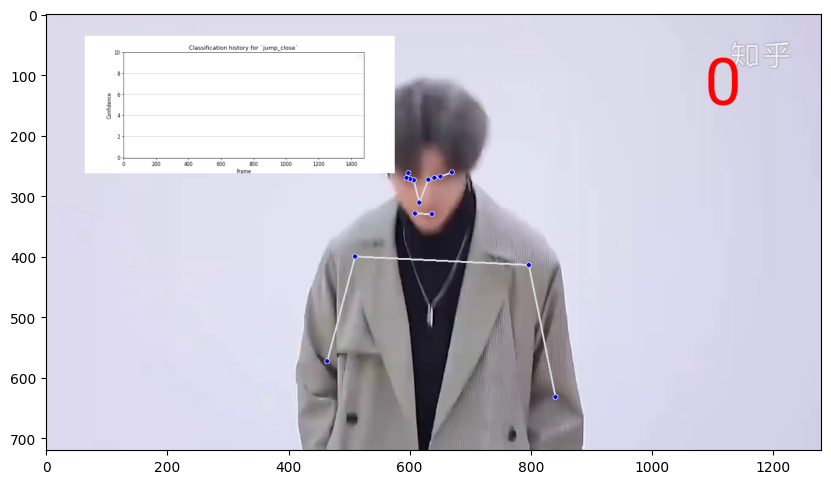

  0%|          | 1/1478.0 [00:07<3:12:23,  7.82s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  0%|          | 2/1478.0 [00:07<1:20:39,  3.28s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  0%|          | 3/1478.0 [00:08<53:28,  2.18s/it]  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  0%|          | 5/1478.0 [00:08<24:36,  1.00s/it]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  0%|    

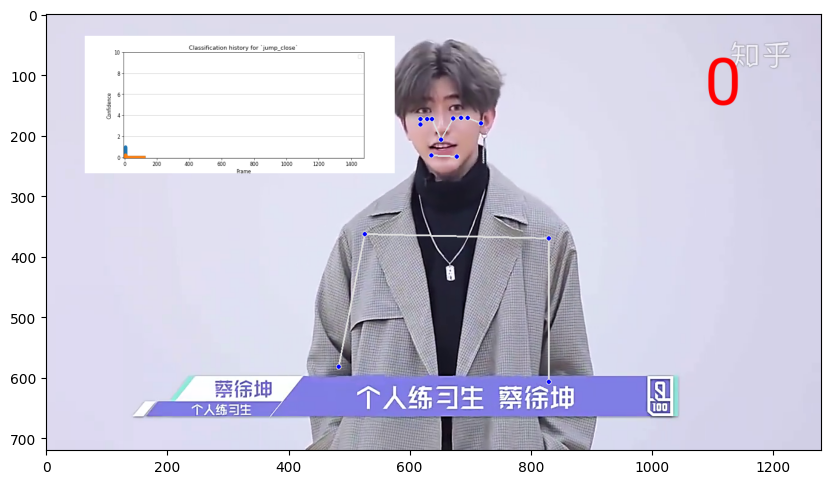

  8%|▊         | 121/1478.0 [00:26<08:09,  2.77it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  8%|▊         | 122/1478.0 [00:27<12:47,  1.77it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  8%|▊         | 123/1478.0 [00:27<10:20,  2.18it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  8%|▊         | 124/1478.0 [00:27<08:38,  2.61it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  8%|▊         | 125/1478.0 [00:27<07:30,  3.00it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignor

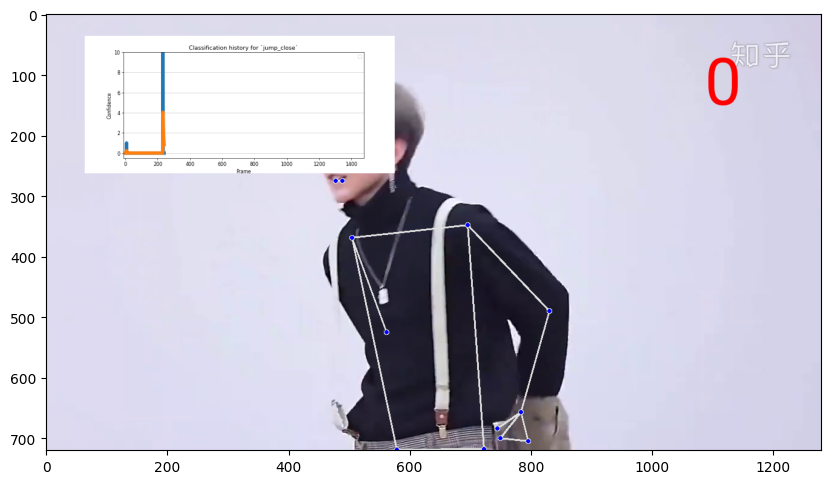

 16%|█▋        | 241/1478.0 [00:52<09:00,  2.29it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 16%|█▋        | 242/1478.0 [00:53<07:37,  2.70it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 16%|█▋        | 243/1478.0 [00:53<06:42,  3.07it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 17%|█▋        | 244/1478.0 [00:53<06:04,  3.38it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 17%|█▋        | 245/1478.0 [00:53<05:38,  3.65it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignor

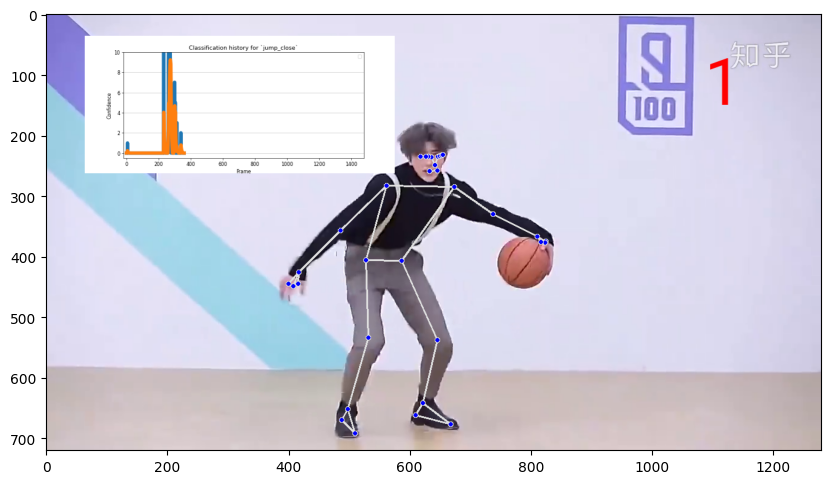

 24%|██▍       | 361/1478.0 [01:15<03:22,  5.51it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 24%|██▍       | 362/1478.0 [01:16<07:47,  2.39it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 25%|██▍       | 363/1478.0 [01:16<06:09,  3.02it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 25%|██▍       | 364/1478.0 [01:16<05:01,  3.70it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 25%|██▍       | 365/1478.0 [01:16<04:09,  4.45it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignor

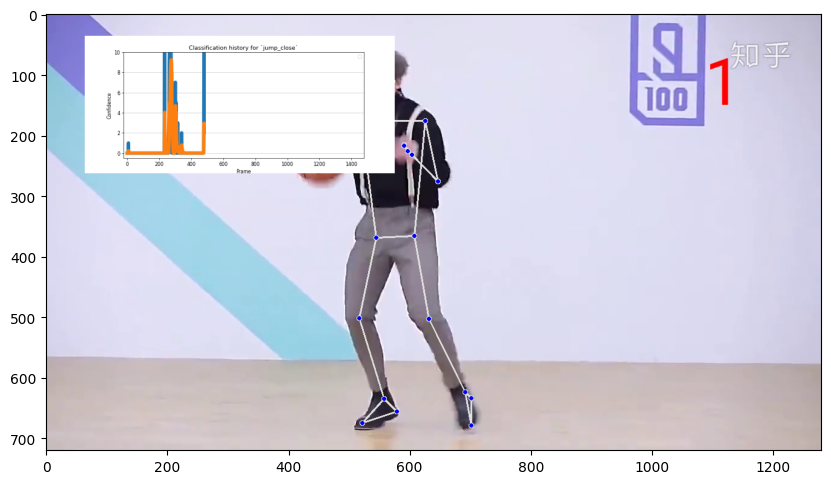

 33%|███▎      | 481/1478.0 [01:30<04:59,  3.33it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 33%|███▎      | 482/1478.0 [01:30<04:09,  4.00it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 33%|███▎      | 483/1478.0 [01:30<03:26,  4.81it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 33%|███▎      | 484/1478.0 [01:30<02:58,  5.58it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 33%|███▎      | 485/1478.0 [01:31<02:36,  6.36it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignor

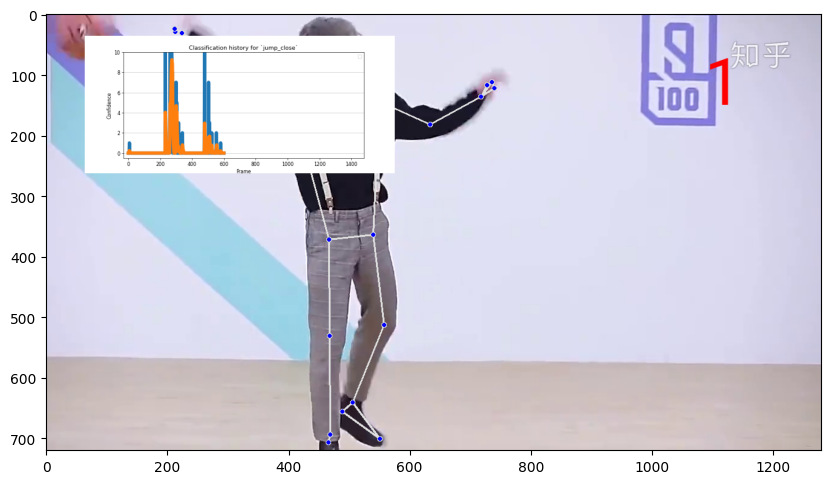

 41%|████      | 601/1478.0 [01:49<05:14,  2.79it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 41%|████      | 602/1478.0 [01:50<10:09,  1.44it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 41%|████      | 603/1478.0 [01:50<08:09,  1.79it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 41%|████      | 604/1478.0 [01:51<06:42,  2.17it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 41%|████      | 605/1478.0 [01:51<05:35,  2.60it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignor

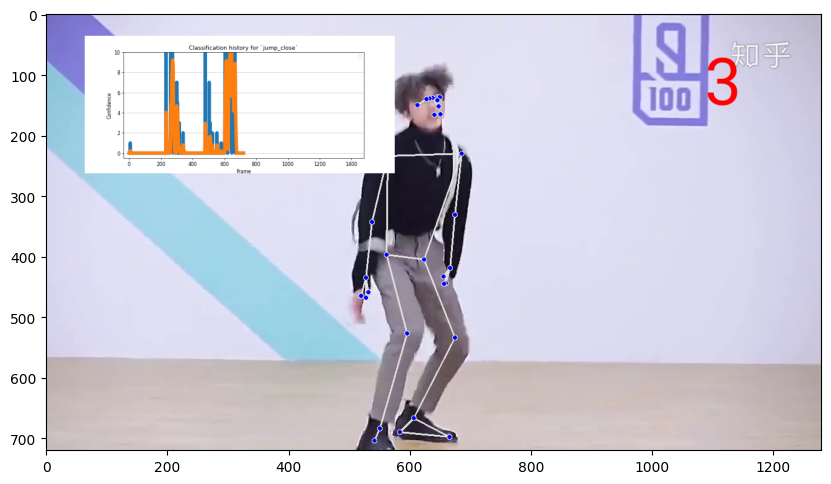

 49%|████▉     | 721/1478.0 [02:13<03:25,  3.69it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 49%|████▉     | 722/1478.0 [02:13<02:47,  4.51it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 49%|████▉     | 723/1478.0 [02:13<02:25,  5.20it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 49%|████▉     | 724/1478.0 [02:13<02:05,  5.99it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 49%|████▉     | 725/1478.0 [02:13<01:53,  6.63it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignor

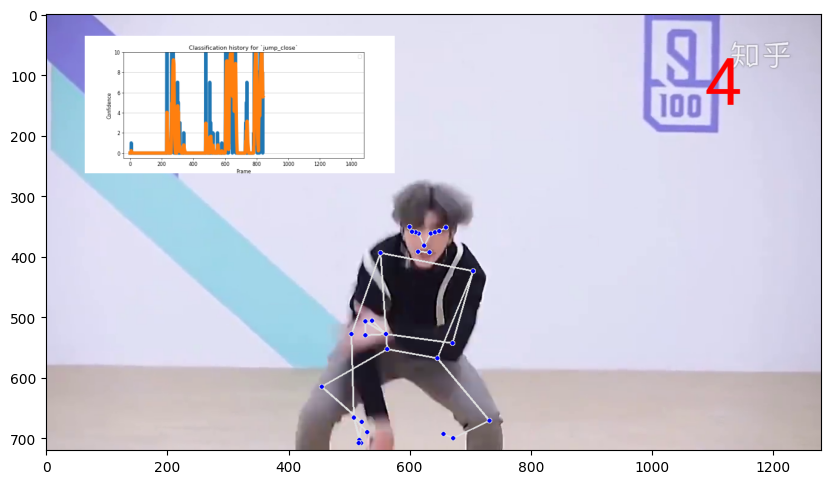

 57%|█████▋    | 841/1478.0 [02:32<03:56,  2.69it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 57%|█████▋    | 842/1478.0 [02:33<06:14,  1.70it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 57%|█████▋    | 843/1478.0 [02:33<04:58,  2.12it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 57%|█████▋    | 844/1478.0 [02:33<04:07,  2.56it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 57%|█████▋    | 845/1478.0 [02:33<03:33,  2.96it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignor

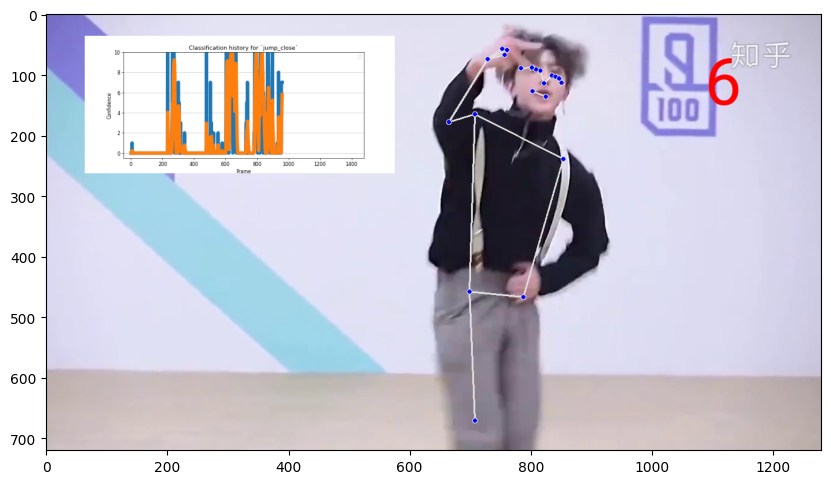

 65%|██████▌   | 961/1478.0 [02:59<03:43,  2.31it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 65%|██████▌   | 962/1478.0 [03:00<03:06,  2.76it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 65%|██████▌   | 963/1478.0 [03:00<02:41,  3.19it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 65%|██████▌   | 964/1478.0 [03:00<02:25,  3.52it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 65%|██████▌   | 965/1478.0 [03:00<02:15,  3.78it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignor

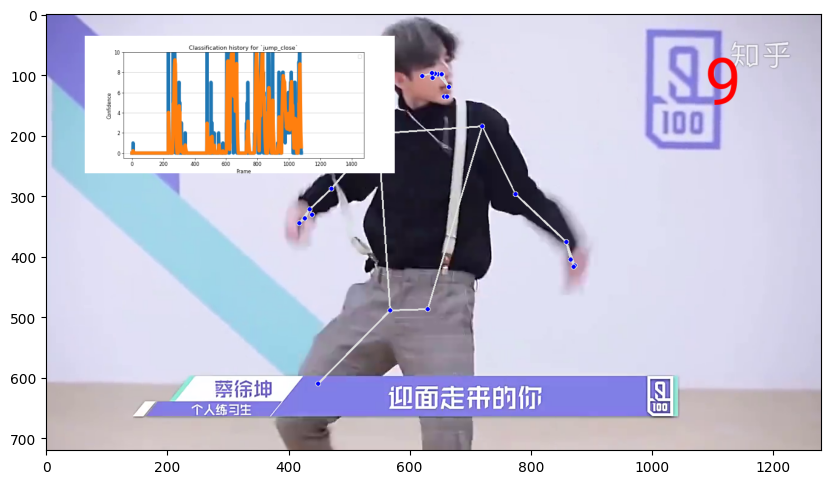

 73%|███████▎  | 1081/1478.0 [03:25<02:08,  3.08it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 73%|███████▎  | 1082/1478.0 [03:26<03:33,  1.86it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 73%|███████▎  | 1083/1478.0 [03:27<02:53,  2.27it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 73%|███████▎  | 1084/1478.0 [03:27<02:24,  2.73it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 73%|███████▎  | 1085/1478.0 [03:27<02:07,  3.08it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are 

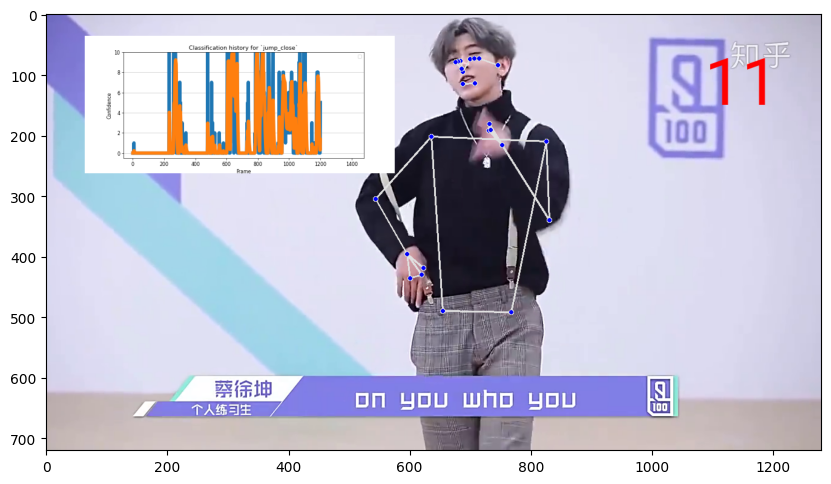

 81%|████████▏ | 1201/1478.0 [03:49<01:43,  2.68it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 81%|████████▏ | 1202/1478.0 [03:49<01:25,  3.22it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 81%|████████▏ | 1203/1478.0 [03:49<01:15,  3.62it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 81%|████████▏ | 1204/1478.0 [03:50<01:08,  4.00it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 82%|████████▏ | 1205/1478.0 [03:50<01:03,  4.30it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are 

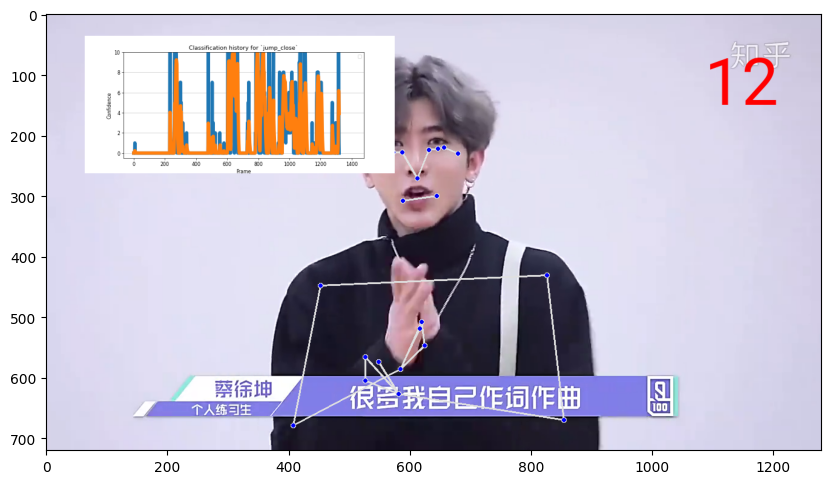

 89%|████████▉ | 1321/1478.0 [04:10<00:39,  4.01it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 89%|████████▉ | 1322/1478.0 [04:11<01:07,  2.31it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 90%|████████▉ | 1323/1478.0 [04:11<00:53,  2.88it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 90%|████████▉ | 1324/1478.0 [04:11<00:44,  3.48it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 90%|████████▉ | 1325/1478.0 [04:11<00:37,  4.05it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are 

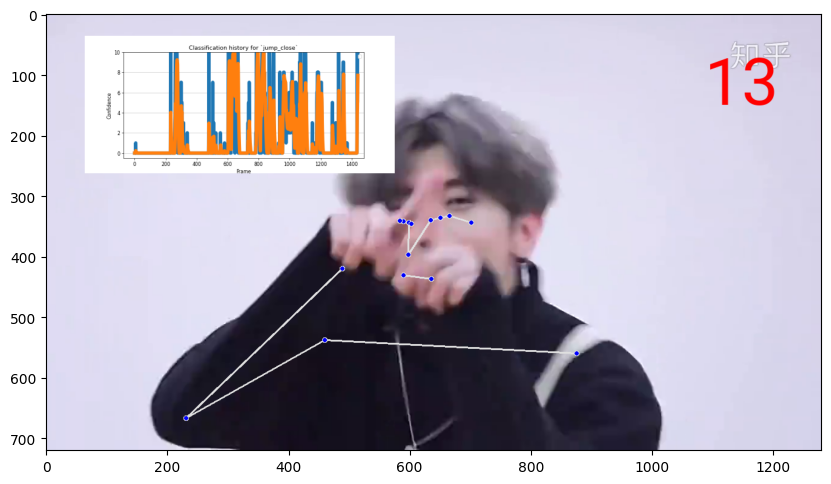

 97%|█████████▋| 1441/1478.0 [04:32<00:13,  2.82it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 98%|█████████▊| 1442/1478.0 [04:32<00:10,  3.35it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 98%|█████████▊| 1443/1478.0 [04:32<00:08,  3.92it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 98%|█████████▊| 1444/1478.0 [04:32<00:07,  4.45it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
 98%|█████████▊| 1445/1478.0 [04:32<00:06,  4.95it/s]No artists with labels found to put in legend.  Note that artists whose label start with an underscore are 

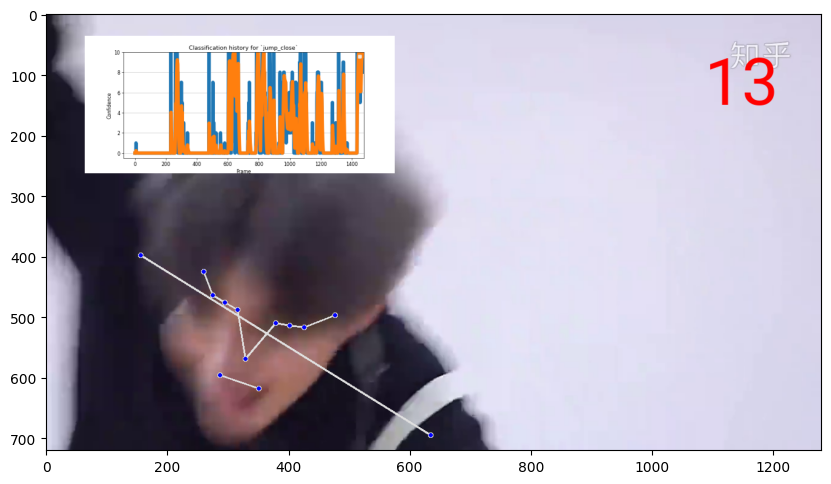

In [30]:
import os
import tqdm
from mediapipe.python.solutions import drawing_utils as mp_drawing

# Open output video
out_video = cv2.VideoWriter(out_video_path, cv2.VideoWriter_fourcc(*'mp4v'), video_fps, (video_width, video_height))

frame_idx = 0
output_frame = None
with tqdm.tqdm(total=video_n_frames, position=0, leave=True) as pbar:
    while True:
        # get next frame of the video
        success, input_frame = video_cap.read()
        if not success:
            break
        # Run pose tracker
        input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
        result = pose_tracker.process(image=input_frame)
        pose_landmarks = result.pose_landmarks

        # draw pose prediction
        output_frame = input_frame.copy()
        if pose_landmarks is not None:
            mp_drawing.draw_landmarks(
                image=output_frame,
                landmark_list=pose_landmarks,
                connections=mp_pose.POSE_CONNECTIONS)

        if pose_landmarks is not None:
            # get landmarks
            frame_height, frame_width = output_frame.shape[0], output_frame.shape[1]
            pose_landmarks = np.array(
                [[lmk.x * frame_width, lmk.y * frame_height, lmk.z * frame_width] for lmk in pose_landmarks.landmark],
                dtype=np.float32)
            assert pose_landmarks.shape == (33, 3), 'Unexpected landmarks shape: {}'.format(pose_landmarks.shape)

            # classify the pose on the current frame
            pose_classification = pose_classifier(pose_landmarks)

            # smooth classification using EMA
            pose_classification_filtered = pose_classification_filter(pose_classification)

            # count repetitions
            repetitions_count = repetition_counter(pose_classification_filtered)
        else:
            # No pose -> no classfication on current frame
            pose_classification = None

            # smoothing for future frames
            pose_classification_filtered = pose_classification_filter(dict())
            pose_classification_filtered = None

            # take the latest repetitions count
            repetitions_count = repetition_counter.n_repeats

        # draw classification plot and repetition counter
        output_frame = pose_classification_visualizer(
            frame=output_frame,
            pose_classification=pose_classification,
            pose_classification_filtered=pose_classification_filtered,
            repetitions_count=repetitions_count)

        # save the output frame
        out_video.write(cv2.cvtColor(np.array(output_frame), cv2.COLOR_RGB2BGR))

        # show intermediate frames of the video to track progress
        if frame_idx % 120 == 0:
            show_image(output_frame)

        frame_idx += 1
        pbar.update()

# close output video
out_video.release()

# releease mediaPipe resources 
pose_tracker.close()

# show the last frame of the video
if output_frame is not None:
    show_image(output_frame)
